# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from RegscorePy import *

In [2]:
pd.options.display.max_rows = 200000

In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Data Loading

## Handling 'NA' values

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.isnull().sum().sum()

6965

There are many columns in the data set which has value 'NA'. If we read the data set using read_csv, by default 'NA' value is being treated as Null which is not ideal for some columns as 'NA' holds some valuable information.

In [6]:
df = pd.read_csv('train.csv', keep_default_na=False)

In [7]:
df.isnull().sum().sum()

0

The above is not again ideal as it ignores all the null values and it will be hard to identify which columns have Null values.

In [8]:
# Removed 'NA' from the list of default values pandas treats as Nulls

df = pd.read_csv('train.csv', keep_default_na=False, na_values=['','#N/A','#N/A N/A','#NA','-1.#IND','-1.#QNAN','-NaN','-nan','1.#IND','1.#QNAN','N/A','NULL','NaN','n/a','nan','null'])

In [9]:
df.isnull().sum().sum()

0

This tells us that there are no Nulls in the data set except for 'NA's which are treated as NULLs in some comlumns.

In [10]:
cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
na_cols = []

na_count = 0

for col in cat_cols:
    na_count = na_count + (df[col]=='NA').sum()
    
for col in cat_cols:
    if (df[col]=='NA').sum() > 0:
        na_cols.append(col) 
    
print(na_count)
print(na_cols)

6965
['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


6965 is the total number of 'NA' values present in the string columns as read by pandas.

Below code takes out the numeric columns that are treated as string columns due to the presence of 'NA'.

In [11]:
na_numeric_cols = []
na_numeric_count = 0
na_string_count = 0

for col in na_cols:
    for value in df[col]:
        if value.isdigit() == True:
            na_numeric_cols.append(col)
            na_numeric_count = na_numeric_count + (df[col]=='NA').sum()
            break

print(na_numeric_cols)
print(na_numeric_count)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
348


Below code gives the actual categorical/string columns that have 'NA' values.

In [12]:
na_cat_cols = na_cols.copy()

for col in na_numeric_cols:
    na_cat_cols.remove(col)
    
na_cat_cols

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [13]:
na_cat_count = 0

for col in na_cat_cols:
    na_cat_count = na_cat_count + (df[col]=='NA').sum()
    
na_cat_count

6617

6617 + 348 = 6965 => Which is the total number of NAs identified in the cat cols.

This was we identified that ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'] columns are supposed to be numeric cols but are getting converted into string columns due to 'NA'.

We will handle this as shown below.

We are explicitly calling out to consider 'NA' values in these columns as Nulls.

In [14]:
df = pd.read_csv('train.csv', keep_default_na=False, na_values={'LotFrontage' : 'NA', 'MasVnrArea' : 'NA', 'GarageYrBlt' : 'NA'})

In [15]:
df.isnull().sum().sum()

348

348 Nulls are coming from converting 'NA's in the columns ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'] to Nulls.

In [16]:
na_count = 0

for col in na_cat_cols:
    na_count = na_count + (df[col]=='NA').sum()
    
na_count

6617

6617 is the number of 'NA's in the other categorical columns which has 'NA's. Thus, the math adds up.

In [17]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave    NA      Reg   
1   2          20       RL         80.0     9600   Pave    NA      Reg   
2   3          60       RL         68.0    11250   Pave    NA      IR1   
3   4          70       RL         60.0     9550   Pave    NA      IR1   
4   5          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0     NA    NA          NA       0   
1         Lvl    AllPub    ...            0     NA    NA          NA       0   
2         Lvl    AllPub    ...            0     NA    NA          NA       0   
3         Lvl    AllPub    ...            0     NA    NA          NA       0   
4         Lvl    AllPub    ...            0     NA    NA          NA       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [18]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Variable Identification

Clearly, "SalePrice" is our target/response variable and the others are predictor variables.

# Data Understanding

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

In [20]:
# Unique data types

df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [21]:
df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

In [22]:
# Categorical columns in the data set

cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]

cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [23]:
# Numeric columns in the data set

numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

numeric_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

## Unique Value Counts

In [24]:
# Unique value counts/frequencies of each column to determine if there are any columns with only a single value/all different values

unique_values = pd.DataFrame(df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)

unique_values['dtype'] = pd.DataFrame(df.dtypes)

unique_values

Unique Value Count    dtype
CentralAir                      2   object
Street                          2   object
Utilities                       2   object
PavedDrive                      3   object
Alley                           3   object
BsmtHalfBath                    3    int64
HalfBath                        3    int64
LandSlope                       3   object
KitchenAbvGr                    4    int64
PoolQC                          4   object
BsmtFullBath                    4    int64
FullBath                        4    int64
ExterQual                       4   object
KitchenQual                     4   object
LandContour                     4   object
LotShape                        4   object
Fireplaces                      4    int64
GarageFinish                    4   object
MiscFeature                     5   object
YrSold                          5    int64
GarageCars                      5    int64
BsmtExposure                    5   object
BsmtCond                        5   object
BsmtQual                        5   object
ExterCond                       5   object
HeatingQC                       5   object
Fence                           5   object
MasVnrType                      5   object
LotConfig                       5   object
MSZoning                        5   object
BldgType                        5   object
Heating                         6   object
RoofStyle                       6   object
GarageQual                      6   object
Electrical                      6   object
Foundation                      6   object
SaleCondition                   6   object
FireplaceQu                     6   object
GarageCond                      6   object
Functional                      7   object
GarageType                      7   object
BsmtFinType2                    7   object
BsmtFinType1                    7   object
PoolArea                        8    int64
BedroomAbvGr                    8    int64
Condition2                      8   object
HouseStyle                      8   object
RoofMatl                        8   object
SaleType                        9   object
Condition1                      9   object
OverallCond                     9    int64
OverallQual                    10    int64
TotRmsAbvGrd                   12    int64
MoSold                         12    int64
MSSubClass                     15    int64
Exterior1st                    15   object
Exterior2nd                    16   object
3SsnPorch                      20    int64
MiscVal                        21    int64
LowQualFinSF                   24    int64
Neighborhood                   25   object
YearRemodAdd                   61    int64
ScreenPorch                    76    int64
GarageYrBlt                    98  float64
LotFrontage                   111  float64
YearBuilt                     112    int64
EnclosedPorch                 120    int64
BsmtFinSF2                    144    int64
OpenPorchSF                   202    int64
WoodDeckSF                    274    int64
MasVnrArea                    328  float64
2ndFlrSF                      417    int64
GarageArea                    441    int64
BsmtFinSF1                    637    int64
SalePrice                     663    int64
TotalBsmtSF                   721    int64
1stFlrSF                      753    int64
BsmtUnfSF                     780    int64
GrLivArea                     861    int64
LotArea                      1073    int64
Id                           1460    int64

Id column can be dropped as it has all different values and doesn't add any value to the analysis.

In [25]:
# Deleting Id column as it has only single value

df.drop('Id', axis=1, inplace=True)
numeric_cols.remove('Id')

In [26]:
# Unique value distribution of the numeric variables

for col in numeric_cols:
    print('\n############################################')
    print('Unique value distribution of ' + str(col))
    print('############################################')
    print(df[col].value_counts(dropna=False).sort_values(ascending = False))


############################################
Unique value distribution of MSSubClass
############################################
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

############################################
Unique value distribution of LotFrontage
############################################
NaN       259
 60.0     143
 70.0      70
 80.0      69
 50.0      57
 75.0      53
 65.0      44
 85.0      40
 78.0      25
 21.0      23
 90.0      23
 24.0      19
 64.0      19
 68.0      19
 73.0      18
 72.0      17
 79.0      17
 63.0      17
 55.0      17
 100.0     16
 51.0      15
 66.0      15
 74.0      15
 52.0      14
 59.0      13
 82.0      12
 40.0      12
 43.0      12
 67.0      12
 57.0      12
 71.0      12
 76.0      11
 69.0      11
 53.0      10
 92.0      10
 88.0      10
 34.0      10
 86.0      10
 44.0    

In [27]:
# Unique value distribution of the categorical variables

for col in cat_cols:
    print('\n############################################')
    print('Unique value distribution of ' + str(col))
    print('############################################')
    print(df[col].value_counts(dropna=False).sort_values(ascending = False))


############################################
Unique value distribution of MSZoning
############################################
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

############################################
Unique value distribution of Street
############################################
Pave    1454
Grvl       6
Name: Street, dtype: int64

############################################
Unique value distribution of Alley
############################################
NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

############################################
Unique value distribution of LotShape
############################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

############################################
Unique value distribution of LandContour
############################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: Lan

## Min Max Values of all columns

In [28]:
# Check if all the values of the variables are in the same scale

numeric_cols = [cname for cname in df.columns if 
                                df[cname].dtype in ['int64', 'float64']]

Max = pd.DataFrame(df[numeric_cols].max().rename('Max'))
Min = pd.DataFrame(df[numeric_cols].min().rename('Min'))

pd.concat([Max, Min], axis=1)

Max      Min
MSSubClass        190.0     20.0
LotFrontage       313.0     21.0
LotArea        215245.0   1300.0
OverallQual        10.0      1.0
OverallCond         9.0      1.0
YearBuilt        2010.0   1872.0
YearRemodAdd     2010.0   1950.0
MasVnrArea       1600.0      0.0
BsmtFinSF1       5644.0      0.0
BsmtFinSF2       1474.0      0.0
BsmtUnfSF        2336.0      0.0
TotalBsmtSF      6110.0      0.0
1stFlrSF         4692.0    334.0
2ndFlrSF         2065.0      0.0
LowQualFinSF      572.0      0.0
GrLivArea        5642.0    334.0
BsmtFullBath        3.0      0.0
BsmtHalfBath        2.0      0.0
FullBath            3.0      0.0
HalfBath            2.0      0.0
BedroomAbvGr        8.0      0.0
KitchenAbvGr        3.0      0.0
TotRmsAbvGrd       14.0      2.0
Fireplaces          3.0      0.0
GarageYrBlt      2010.0   1900.0
GarageCars          4.0      0.0
GarageArea       1418.0      0.0
WoodDeckSF        857.0      0.0
OpenPorchSF       547.0      0.0
EnclosedPorch     552.0      0.0
3SsnPorch         508.0      0.0
ScreenPorch       480.0      0.0
PoolArea          738.0      0.0
MiscVal         15500.0      0.0
MoSold             12.0      1.0
YrSold           2010.0   2006.0
SalePrice      755000.0  34900.0

Values of some variables like MasVnrArea has a huge difference in the min and max values.

# Data Cleaning

## Standardizing Values

In [29]:
# Convert all text column values to lower case

for col in cat_cols:
    df[col] = df[col].str.lower()

In [30]:
# There is a chance of having duplicate values due to spelling mistakes of the same variable value

for col in cat_cols:
    print('\n################################')
    print('Unique values of ' + str(col))
    print('################################')
    print(pd.Series(df[col].unique()).sort_values(ascending=False))


################################
Unique values of MSZoning
################################
1         rm
0         rl
4         rh
3         fv
2    c (all)
dtype: object

################################
Unique values of Street
################################
0    pave
1    grvl
dtype: object

################################
Unique values of Alley
################################
2    pave
0      na
1    grvl
dtype: object

################################
Unique values of LotShape
################################
0    reg
3    ir3
2    ir2
1    ir1
dtype: object

################################
Unique values of LandContour
################################
0    lvl
2    low
3    hls
1    bnk
dtype: object

################################
Unique values of Utilities
################################
1    nosewa
0    allpub
dtype: object

################################
Unique values of LotConfig
################################
0     inside
4        fr3
1        fr2
3    culdsac
2 

No spelling mistakes found in any of the variable values.

## Duplicates

In [31]:
df.duplicated().value_counts()

False    1460
dtype: int64

There are no duplicate rows in the data set.

## Missing Values

In [32]:
# % of nulls in each column

null_series = pd.Series(round(100*(df.isnull().sum(axis=0)/len(df.index)), 2).sort_values(ascending = False))
null_series.loc[null_series.values > 0]

LotFrontage    17.74
GarageYrBlt     5.55
MasVnrArea      0.55
dtype: float64

In [33]:
# Imputation

df['LotFrontage'].fillna(value=df['LotFrontage'].quantile(0.75) - df['LotFrontage'].quantile(0.25), inplace=True)
df['GarageYrBlt'].fillna(value=df['GarageYrBlt'].mode().values[0], inplace=True)
df['MasVnrArea'].fillna(value=df['MasVnrArea'].quantile(0.75) - df['MasVnrArea'].quantile(0.25), inplace=True)

Imputed nulls of LotFrontage & MasVnrArea with IQR.

Imputed nulls of GarageYrBlt with mode.

In [34]:
# % of nulls in each column

null_series = pd.Series(round(100*(df.isnull().sum(axis=0)/len(df.index)), 2).sort_values(ascending = False))
null_series.loc[null_series.values > 0]

Series([], dtype: float64)

Now, there are no nulls in the data set.

# EDA

## Univariate Analysis

In [35]:
def univariate_continuos(df):
    
    numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    
    for col in numeric_cols:
    
        sns.boxplot(df[col])
        plt.title(col)
        plt.show()

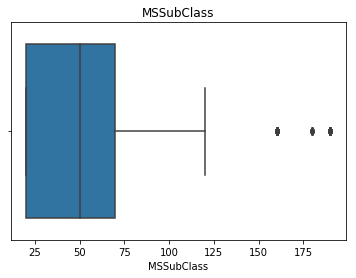

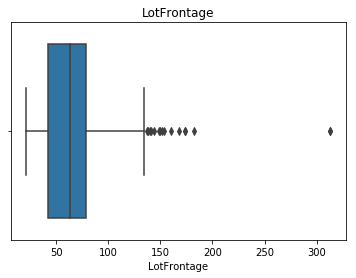

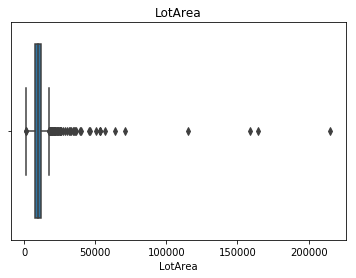

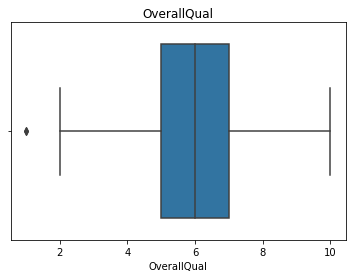

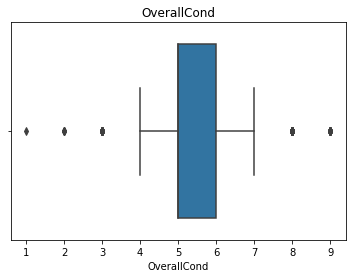

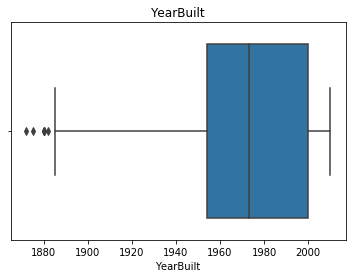

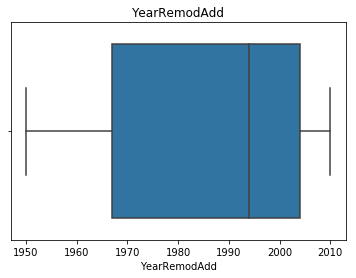

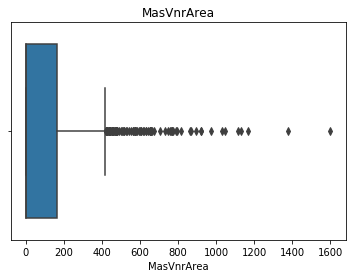

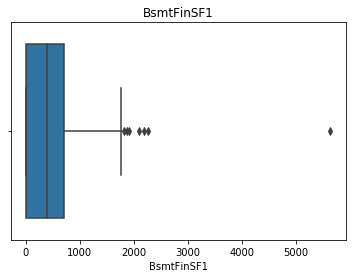

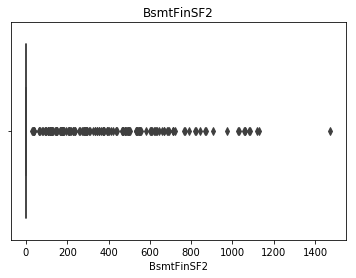

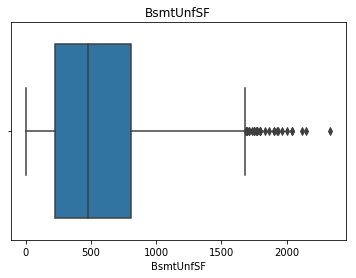

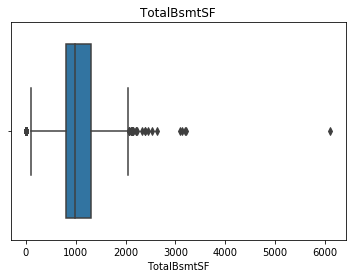

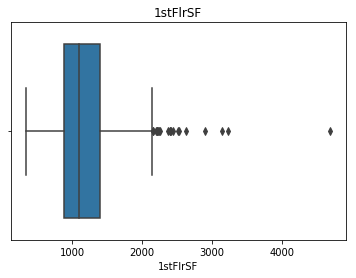

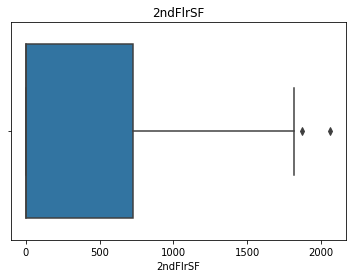

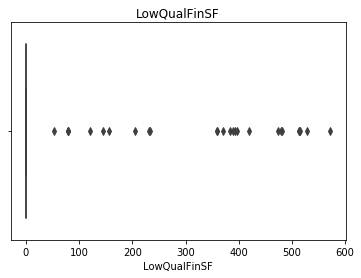

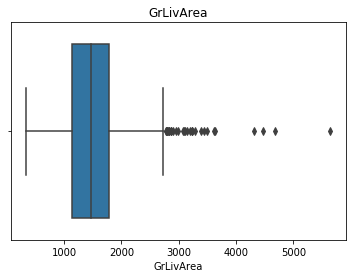

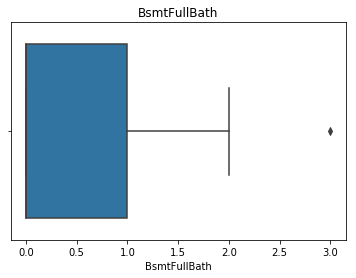

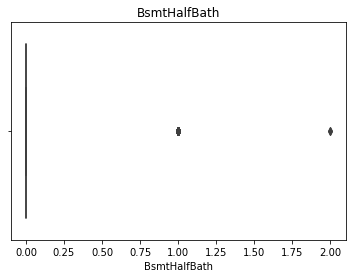

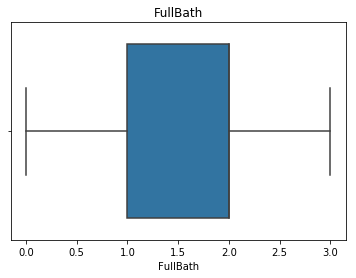

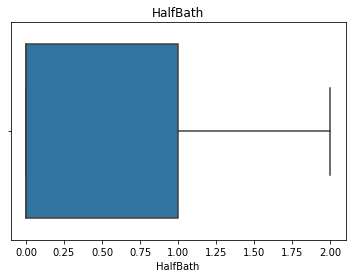

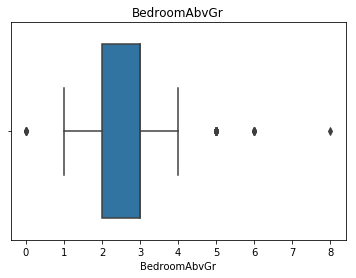

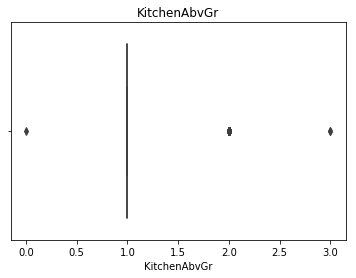

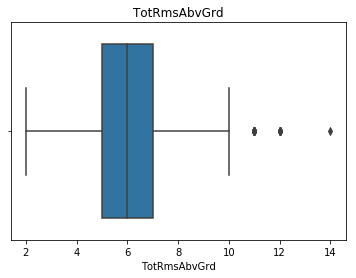

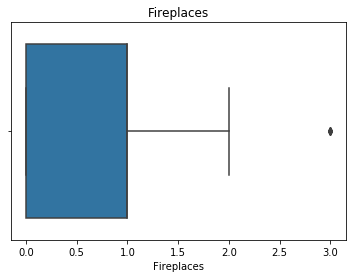

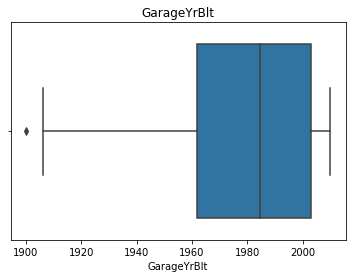

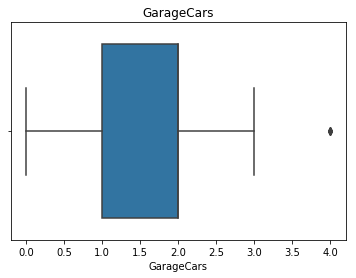

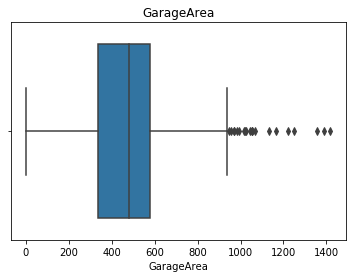

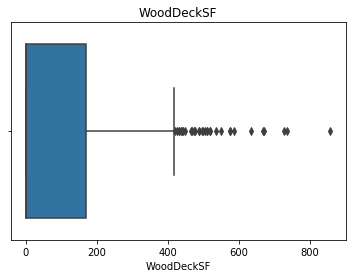

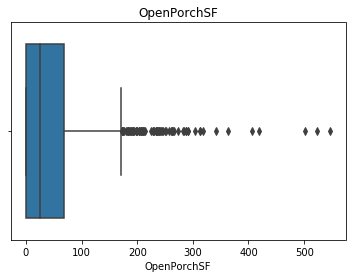

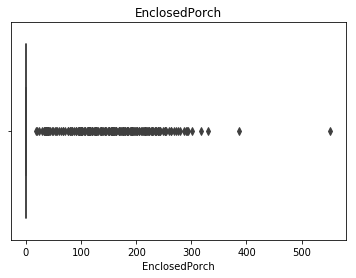

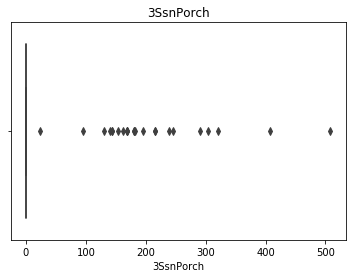

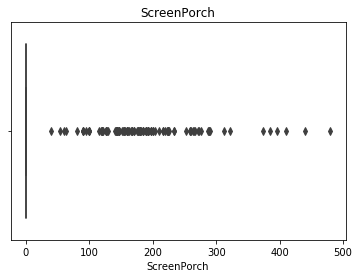

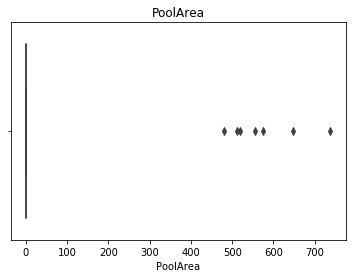

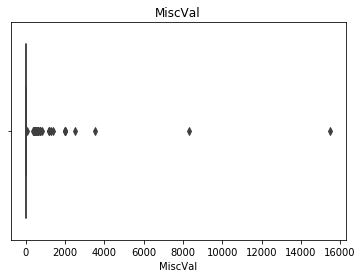

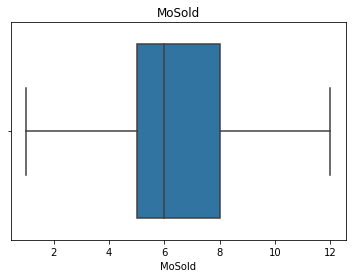

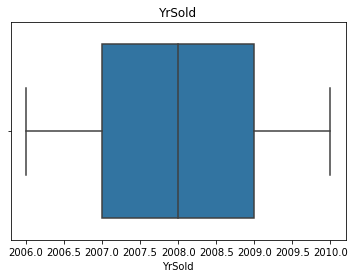

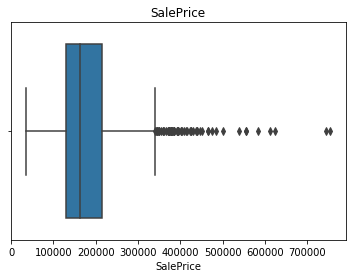

In [36]:
univariate_continuos(df)

We see outliers in a lot of variables. This will be handled in the outlier treatment section.

In [37]:
def bivariate_continuos(df, target):

    numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64', 'uint8']]
    
    for col in numeric_cols:
        sns.regplot(x=col, y=target, data=df)
        plt.show()

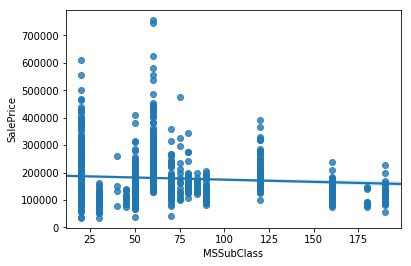

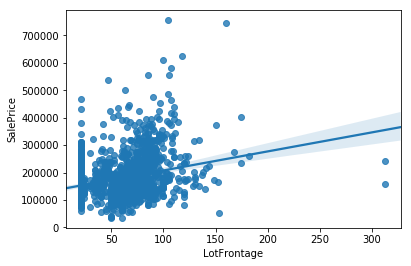

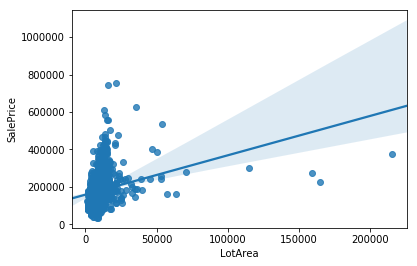

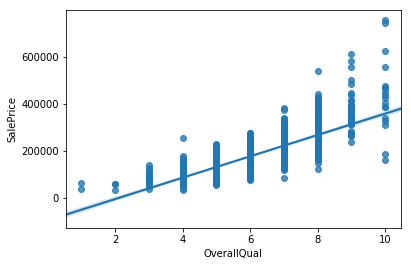

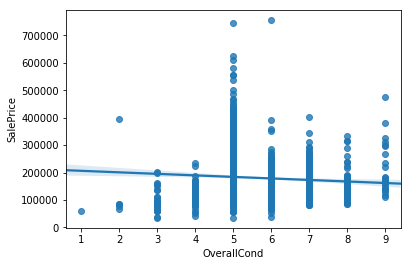

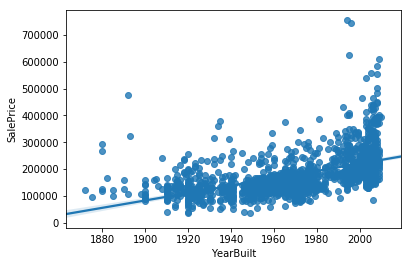

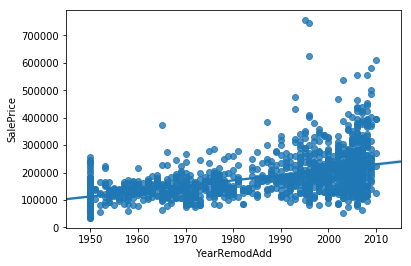

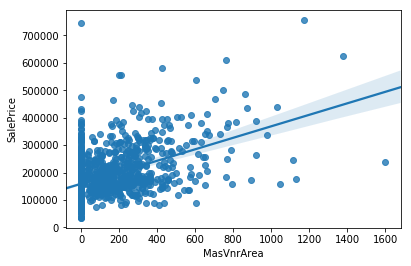

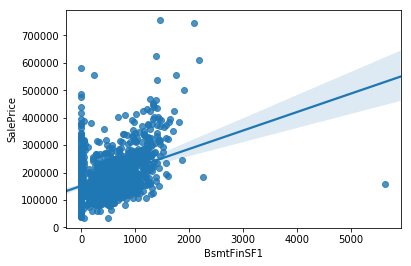

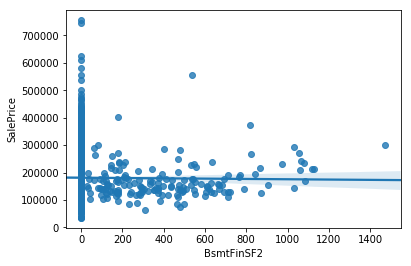

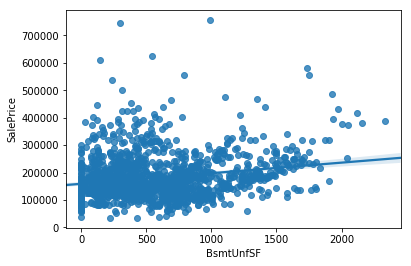

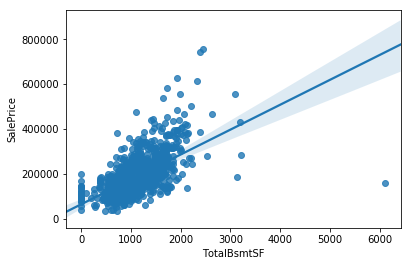

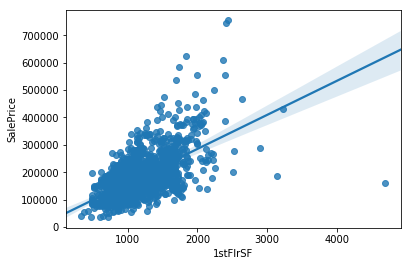

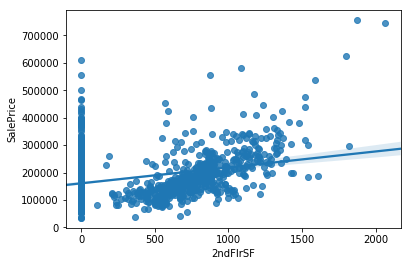

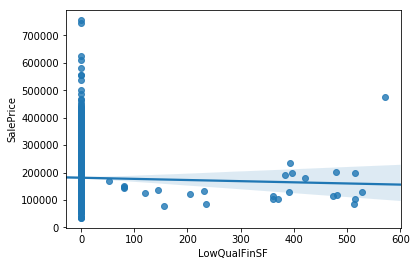

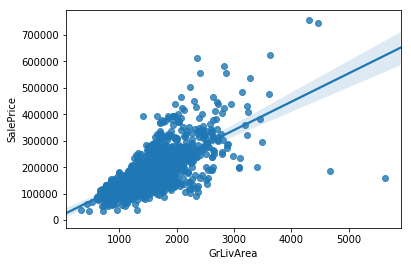

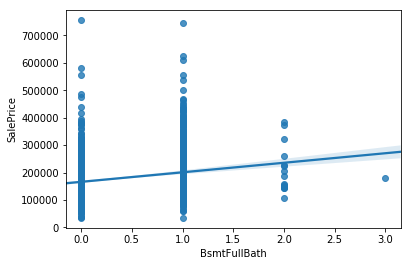

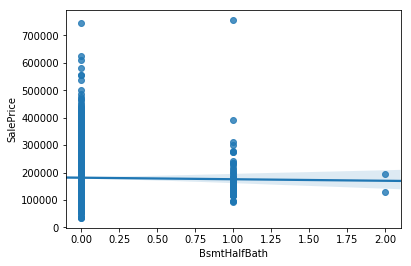

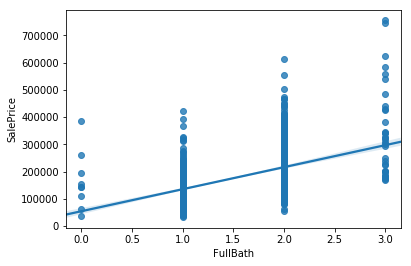

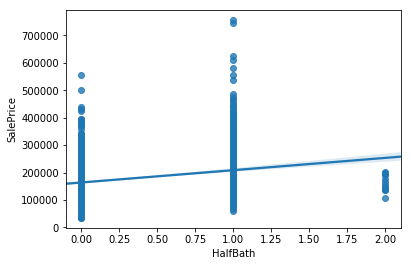

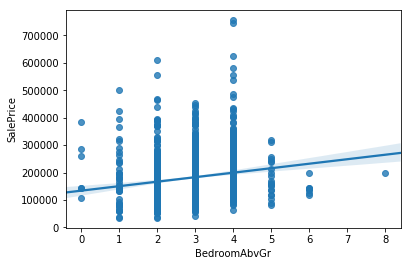

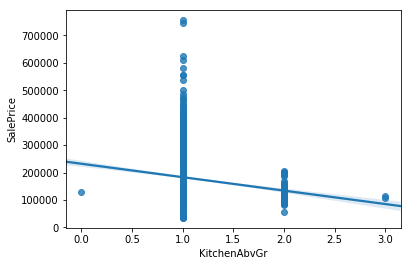

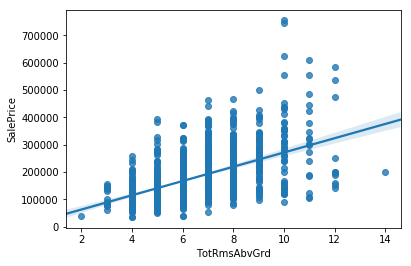

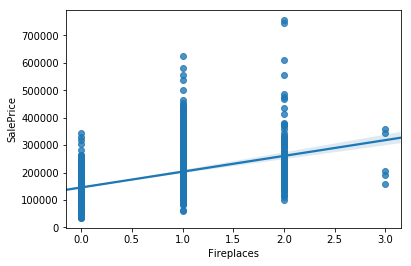

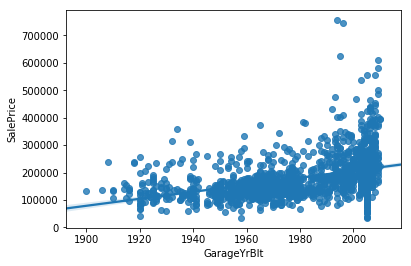

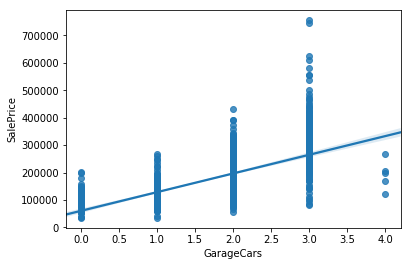

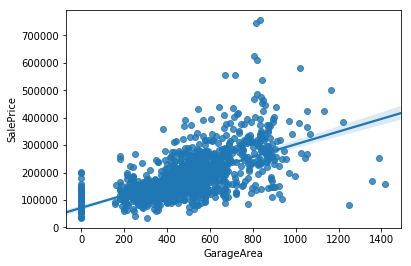

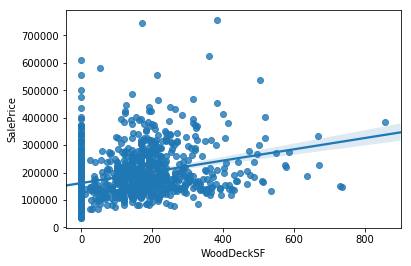

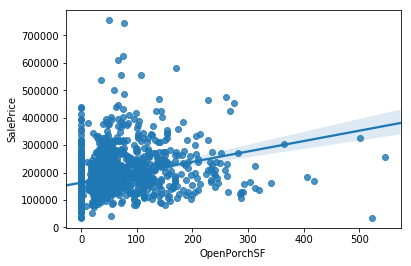

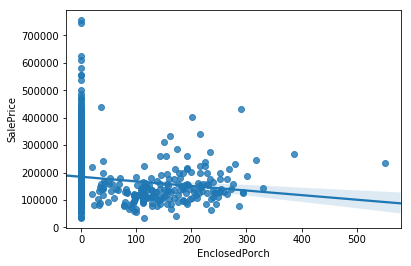

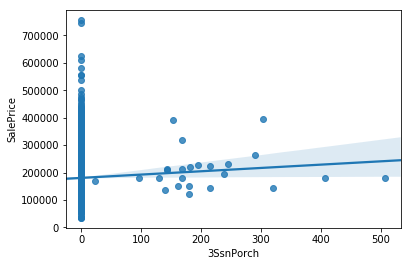

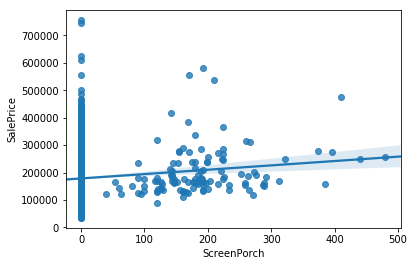

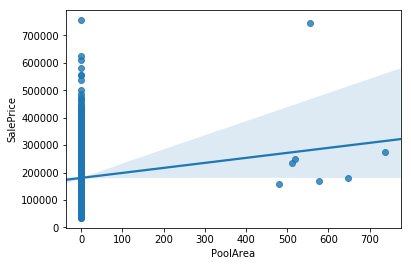

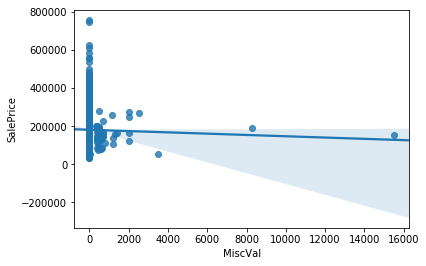

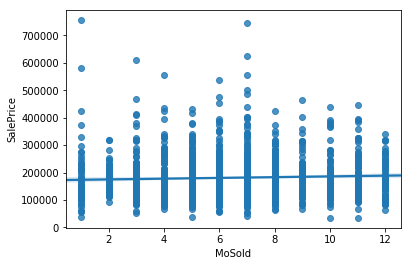

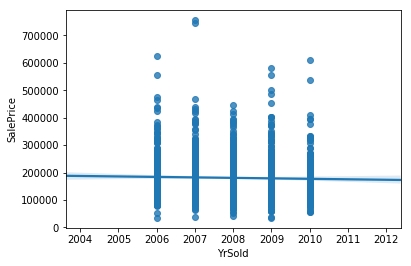

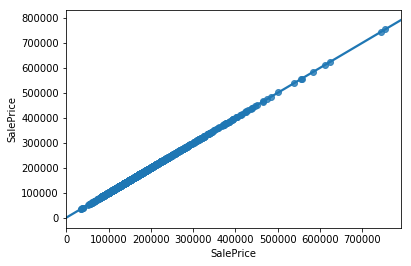

In [38]:
bivariate_continuos(df, 'SalePrice')

Scatter plots with the target variable "SalePrice" doesn't show a need for any feature transformation.

## Multivariate Analysis

<Figure size 1440x720 with 0 Axes>

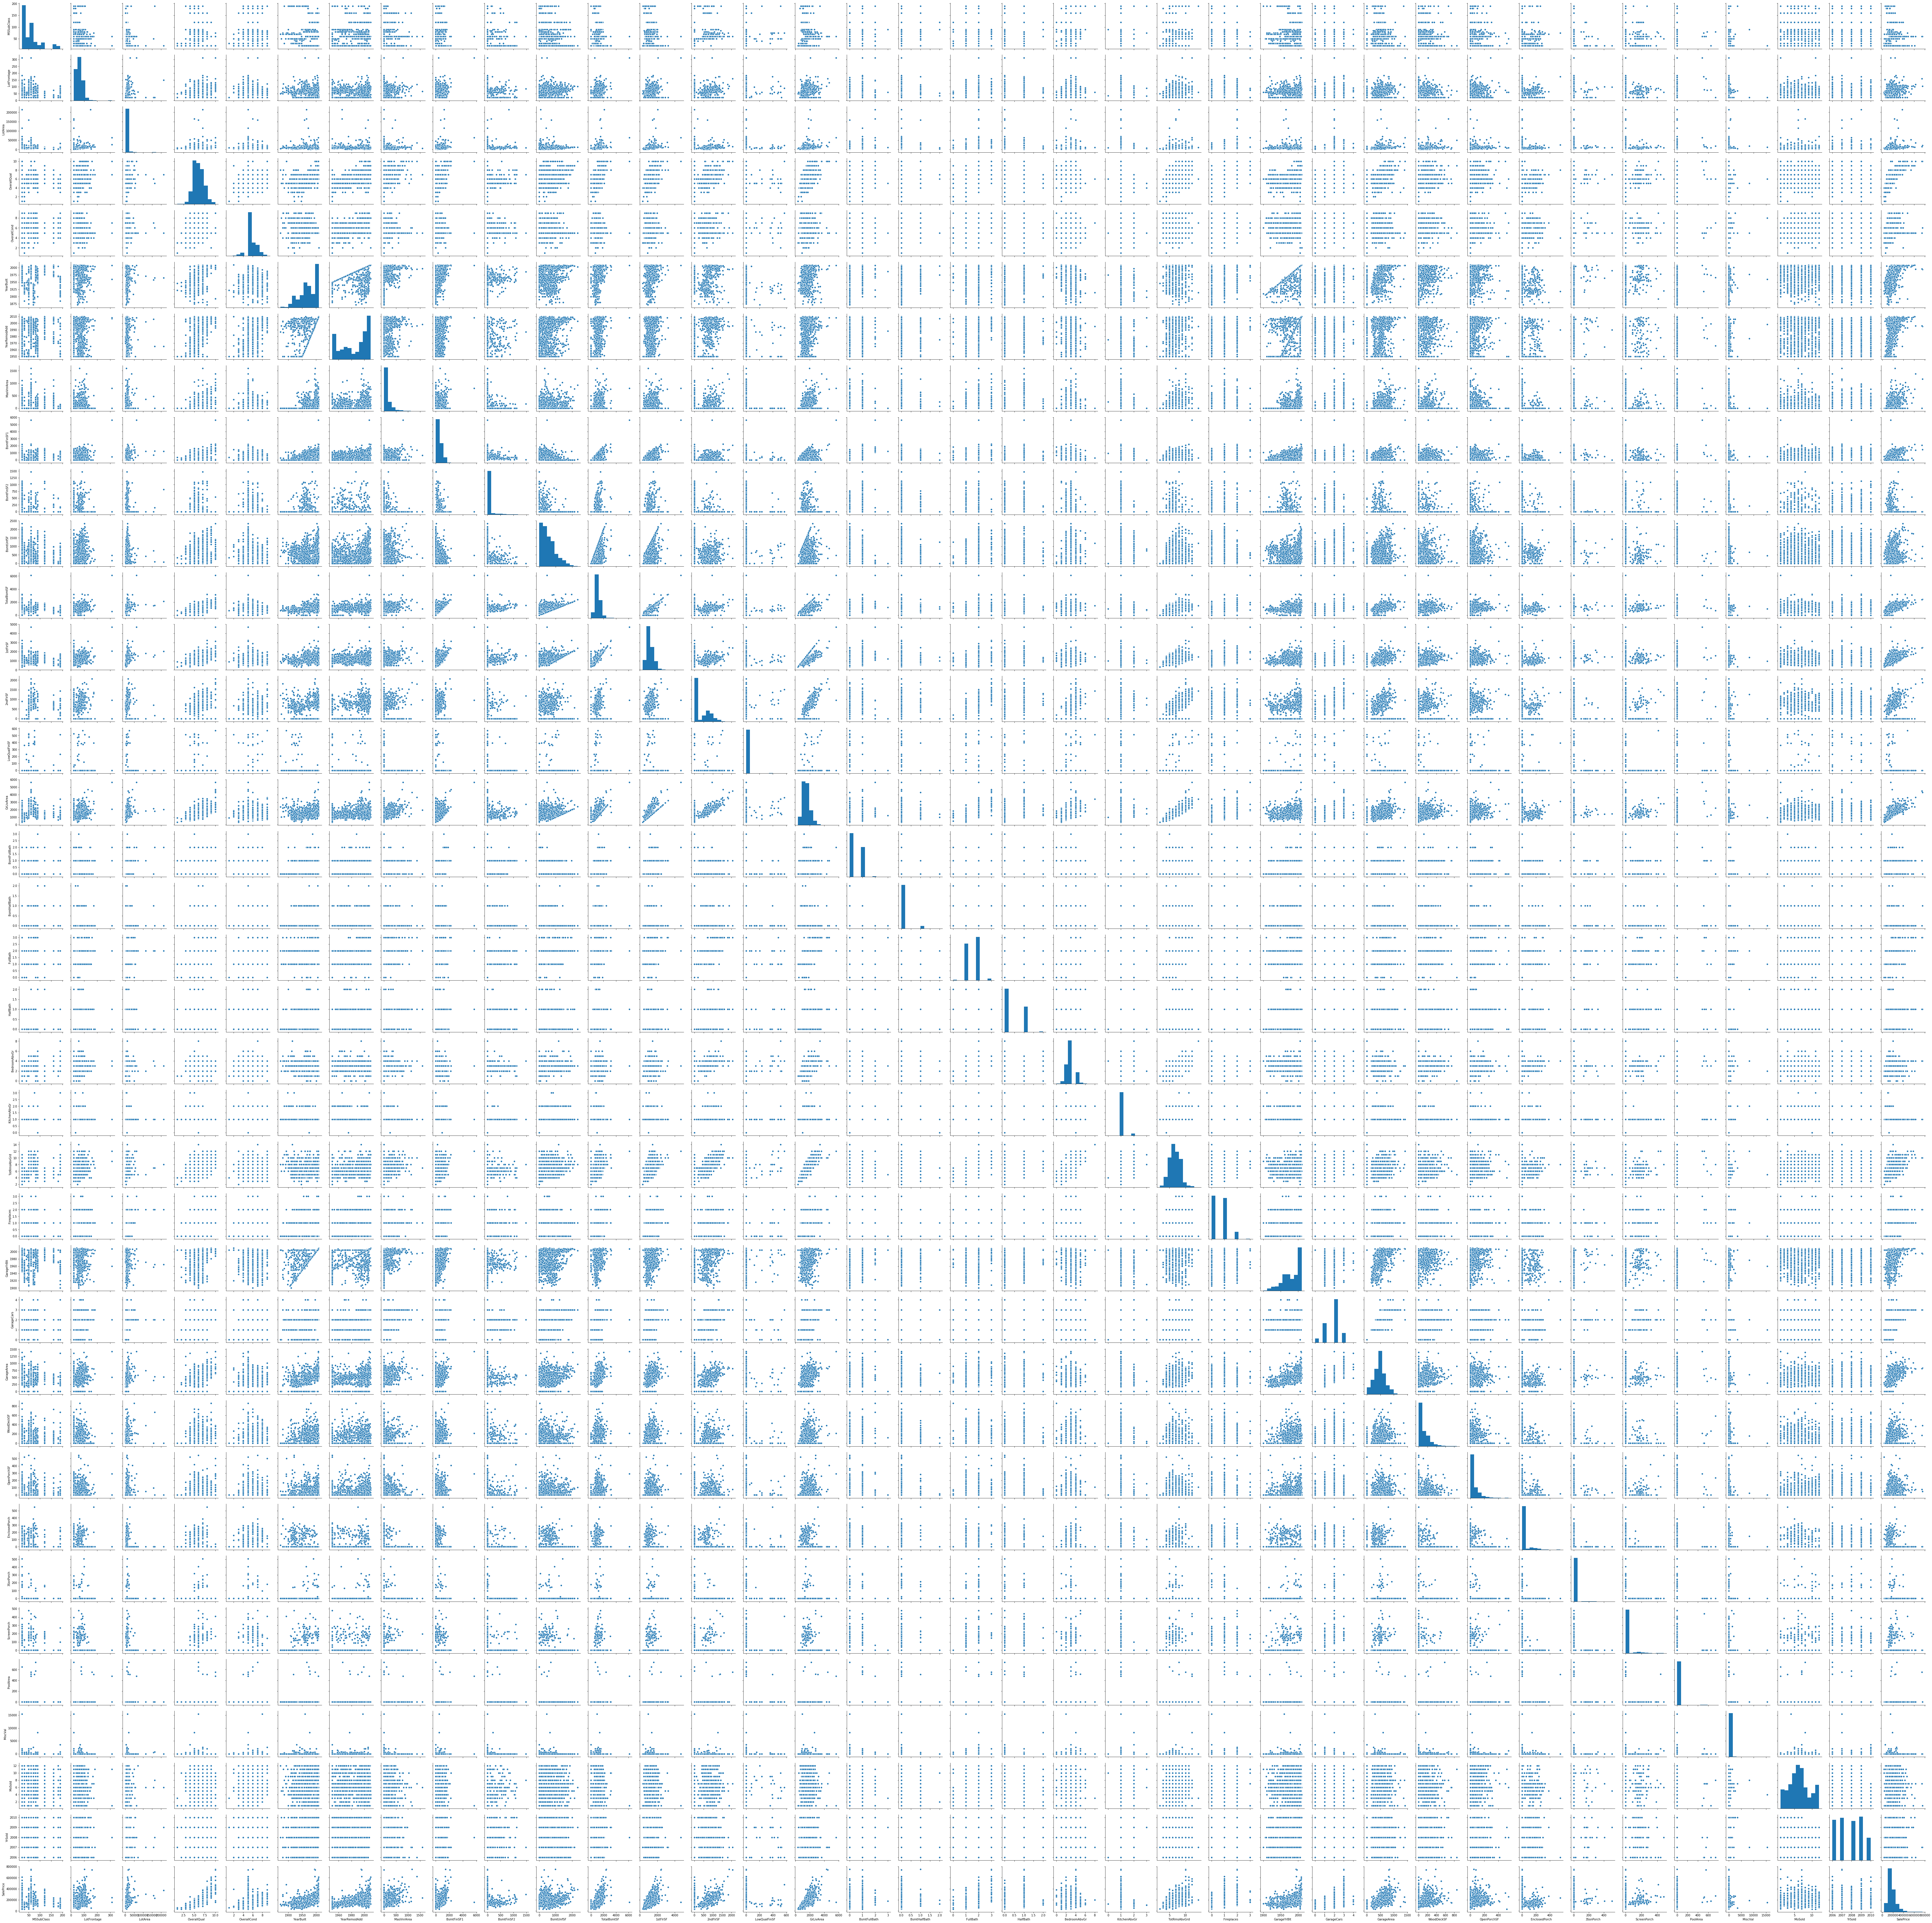

In [39]:
# paiwise scatter plot

plt.figure(figsize=(20, 10))
sns.pairplot(df[numeric_cols])
plt.show()

This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [40]:
df[numeric_cols].corr()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.261981 -0.139781     0.032628    -0.059316   
LotFrontage     -0.261981     1.000000  0.154590     0.201652    -0.056925   
LotArea         -0.139781     0.154590  1.000000     0.105806    -0.005636   
OverallQual      0.032628     0.201652  0.105806     1.000000    -0.091932   
OverallCond     -0.059316    -0.056925 -0.005636    -0.091932     1.000000   
YearBuilt        0.027850     0.057778  0.014228     0.572323    -0.375983   
YearRemodAdd     0.040581     0.084931  0.013788     0.550684     0.073741   
MasVnrArea       0.022467     0.128900  0.104255     0.411678    -0.128937   
BsmtFinSF1      -0.069836     0.113622  0.214103     0.239666    -0.046231   
BsmtFinSF2      -0.065649     0.002079  0.111170    -0.059119     0.040229   
BsmtUnfSF       -0.140759     0.162870 -0.002618     0.308159    -0.136841   
TotalBsmtSF     -0.238518     0.282934  0.260833     0.537808    -0.171098   
1stFlrSF        -0.251758     0.300354  0.299475     0.476224    -0.144203   
2ndFlrSF         0.307886     0.052259  0.050986     0.295493     0.028942   
LowQualFinSF     0.046474     0.050361  0.004779    -0.030429     0.025494   
GrLivArea        0.074853     0.269038  0.263116     0.593007    -0.079686   
BsmtFullBath     0.003491     0.029710  0.158155     0.111098    -0.054942   
BsmtHalfBath    -0.002333    -0.024844  0.048046    -0.040150     0.117821   
FullBath         0.131608     0.142365  0.126031     0.550600    -0.194149   
HalfBath         0.177354     0.000147  0.014259     0.273458    -0.060769   
BedroomAbvGr    -0.023438     0.175384  0.119690     0.101676     0.012980   
KitchenAbvGr     0.281721     0.027567 -0.017784    -0.183882    -0.087001   
TotRmsAbvGrd     0.040380     0.258904  0.190015     0.427452    -0.057583   
Fireplaces      -0.045569     0.090766  0.271364     0.396765    -0.023820   
GarageYrBlt      0.098664     0.040506 -0.042198     0.437998    -0.299203   
GarageCars      -0.040110     0.200253  0.154871     0.600671    -0.185758   
GarageArea      -0.098672     0.242986  0.180403     0.562022    -0.151521   
WoodDeckSF      -0.012579     0.003520  0.171698     0.238923    -0.003334   
OpenPorchSF     -0.006100     0.089799  0.084774     0.308819    -0.032589   
EnclosedPorch   -0.012037     0.025203 -0.018340    -0.113937     0.070356   
3SsnPorch       -0.043825     0.033953  0.020423     0.030371     0.025504   
ScreenPorch     -0.026030     0.027881  0.043160     0.064886     0.054811   
PoolArea         0.008283     0.137060  0.077672     0.065166    -0.001985   
MiscVal         -0.007683    -0.049760  0.038068    -0.031406     0.068777   
MoSold          -0.013585     0.018217  0.001205     0.070815    -0.003511   
YrSold          -0.021407    -0.008605 -0.014261    -0.027347     0.043950   
SalePrice       -0.084284     0.252392  0.263843     0.790982    -0.077856   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass      0.027850      0.040581    0.022467   -0.069836   -0.065649   
LotFrontage     0.057778      0.084931    0.128900    0.113622    0.002079   
LotArea         0.014228      0.013788    0.104255    0.214103    0.111170   
OverallQual     0.572323      0.550684    0.411678    0.239666   -0.059119   
OverallCond    -0.375983      0.073741   -0.128937   -0.046231    0.040229   
YearBuilt       1.000000      0.592855    0.316364    0.249503   -0.049107   
YearRemodAdd    0.592855      1.000000    0.180630    0.128451   -0.067759   
MasVnrArea      0.316364      0.180630    1.000000    0.264753   -0.072825   
BsmtFinSF1      0.249503      0.128451    0.264753    1.000000   -0.050117   
BsmtFinSF2     -0.049107     -0.067759   -0.072825   -0.050117    1.000000   
BsmtUnfSF       0.149040      0.181133    0.114278   -0.495251   -0.209294   
TotalBsmtSF     0.391452      0.291066    0.363573    0.522396    0.104810   
1stFlrSF        0.281986      0.2403

SalePrice is highly correlated with OverallQual. Let's see if this shows up in the results of the Ridge/Lasso regression.

# Outlier Treatment

In [41]:
def outlier_treatment(df, col):

    print('#########################')
    print(col)
    print('#########################')
    
    Q1 = df[col].quantile(0.25)
    print('Q1 is => ' + str(Q1))

    Q3 = df[col].quantile(0.75)
    print('Q3 is => ' + str(Q3))

    IQR = Q3 - Q1

    fence_low  = Q1-1.5*IQR
    print('Fence Low is => ' + str(fence_low))

    fence_high = Q3+1.5*IQR
    print('Fence High is => ' + str(fence_high))

    df.loc[(df[col] > fence_high), col] = fence_high
    df.loc[(df[col] < fence_low), col] = fence_low
    
    print('\n')
    
    return df

def outlier_treatment_max(df, col):

    print('#########################')
    print(col)
    print('#########################')
    
    Q1 = df[col].quantile(0.25)
    print('Q1 is => ' + str(Q1))

    Q3 = df[col].quantile(0.75)
    print('Q3 is => ' + str(Q3))

    IQR = Q3 - Q1

    fence_high = Q3+1.5*IQR
    print('Fence High is => ' + str(fence_high))

    df.loc[(df[col] > fence_high), col] = fence_high
    
    print('\n')
    
    return df

def outlier_treatment_min(df, col):

    print('#########################')
    print(col)
    print('#########################')
    
    Q1 = df[col].quantile(0.25)
    print('Q1 is => ' + str(Q1))

    Q3 = df[col].quantile(0.75)
    print('Q3 is => ' + str(Q3))

    IQR = Q3 - Q1

    fence_low  = Q1-1.5*IQR
    print('Fence Low is => ' + str(fence_low))

    df.loc[(df[col] < fence_low), col] = fence_low
    
    print('\n')
    
    return df

In [42]:
df = outlier_treatment_max(df, 'MSSubClass')
df = outlier_treatment_max(df, 'LotFrontage')
df = outlier_treatment_max(df, 'LotArea')
df = outlier_treatment(df, 'OverallCond')
df = outlier_treatment_max(df, 'MasVnrArea')
df = outlier_treatment_max(df, 'BsmtFinSF1')
df = outlier_treatment_max(df, 'BsmtFinSF2')
df = outlier_treatment_max(df, 'BsmtUnfSF')
df = outlier_treatment_max(df, 'TotalBsmtSF')
df = outlier_treatment_max(df, '1stFlrSF')
df = outlier_treatment_max(df, '2ndFlrSF')
df = outlier_treatment_max(df, 'LowQualFinSF')
df = outlier_treatment_max(df, 'GrLivArea')
df = outlier_treatment_max(df, 'BsmtHalfBath')
df = outlier_treatment(df, 'BedroomAbvGr')
df = outlier_treatment(df, 'KitchenAbvGr')
df = outlier_treatment_max(df, 'TotRmsAbvGrd')
df = outlier_treatment_max(df, 'GarageArea')
df = outlier_treatment_max(df, 'WoodDeckSF')
df = outlier_treatment_max(df, 'OpenPorchSF')
df = outlier_treatment_max(df, 'EnclosedPorch')
df = outlier_treatment_max(df, '3SsnPorch')
df = outlier_treatment_max(df, 'ScreenPorch')
df = outlier_treatment_max(df, 'PoolArea')
df = outlier_treatment_max(df, 'MiscVal')

#########################
MSSubClass
#########################
Q1 is => 20.0
Q3 is => 70.0
Fence High is => 145.0


#########################
LotFrontage
#########################
Q1 is => 42.0
Q3 is => 79.0
Fence High is => 134.5


#########################
LotArea
#########################
Q1 is => 7553.5
Q3 is => 11601.5
Fence High is => 17673.5


#########################
OverallCond
#########################
Q1 is => 5.0
Q3 is => 6.0
Fence Low is => 3.5
Fence High is => 7.5


#########################
MasVnrArea
#########################
Q1 is => 0.0
Q3 is => 166.0
Fence High is => 415.0


#########################
BsmtFinSF1
#########################
Q1 is => 0.0
Q3 is => 712.25
Fence High is => 1780.625


#########################
BsmtFinSF2
#########################
Q1 is => 0.0
Q3 is => 0.0
Fence High is => 0.0


#########################
BsmtUnfSF
#########################
Q1 is => 223.0
Q3 is => 808.0
Fence High is => 1685.5


#########################
TotalBsmtSF
##########

If the outliers are on the higher end of the variable value, imputed the values which are greater than Q3+1.5*IQR with Q3+1.5*IQR.

If the outliers on the lower end of the variable value, imputed the values which are lesser than Q1-1.5*IQR with Q1-1.5*IQR.

If the outliers are on both the ends of the variable values, imputed the values which are greater than Q3+1.5*IQR with Q3+1.5*IQR and which are lesser than Q1-1.5*IQR with Q1-1.5*IQR.

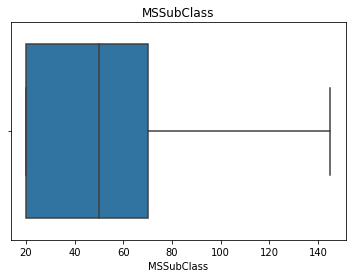

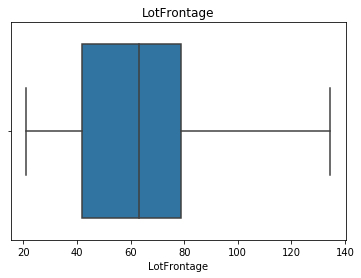

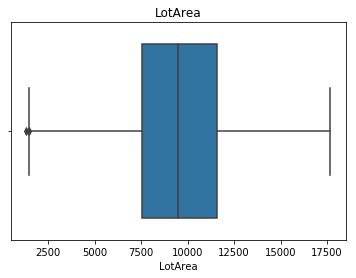

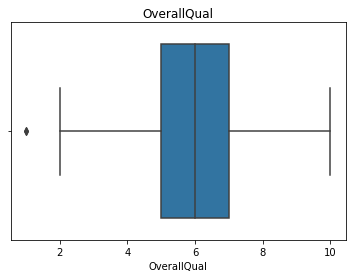

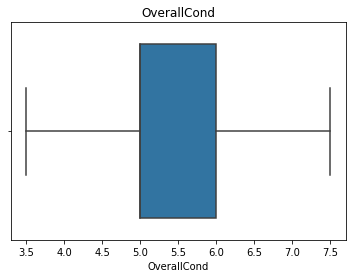

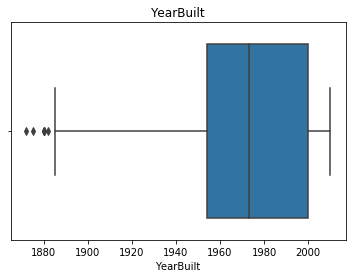

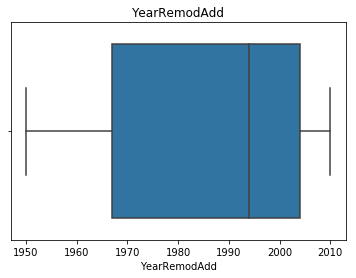

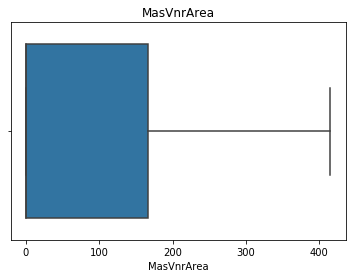

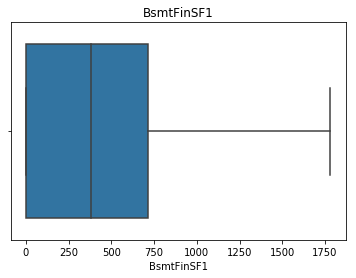

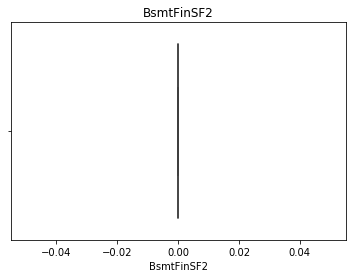

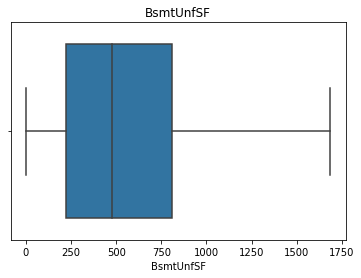

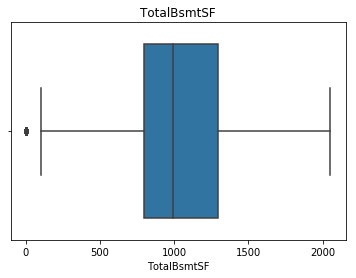

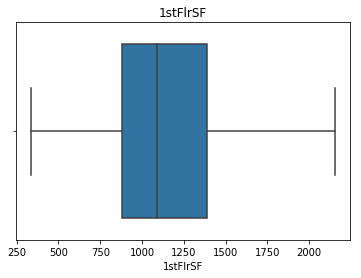

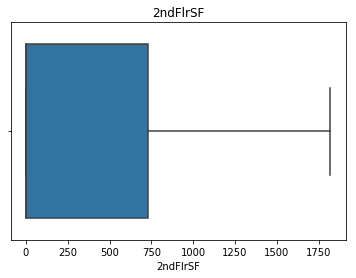

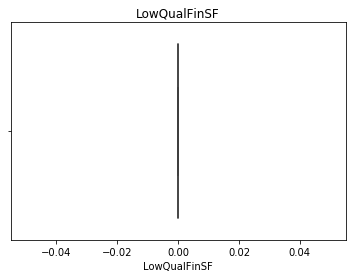

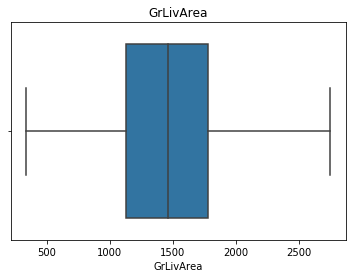

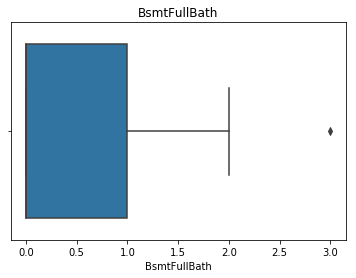

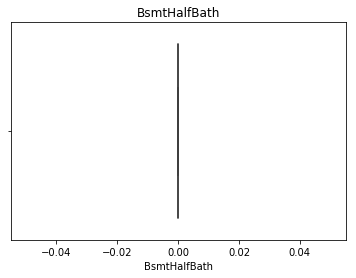

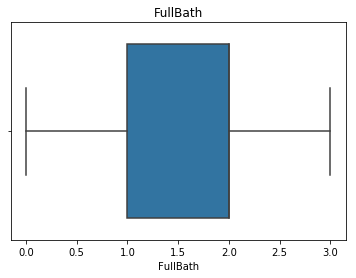

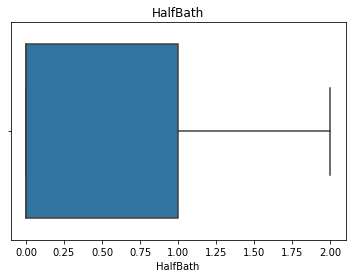

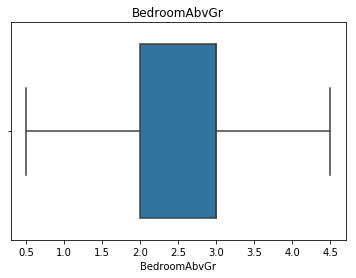

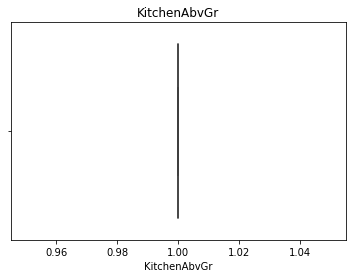

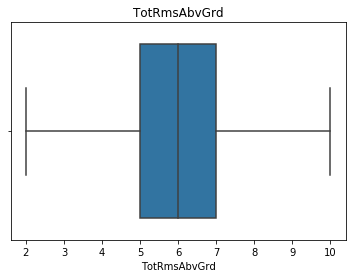

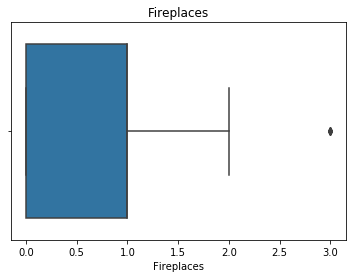

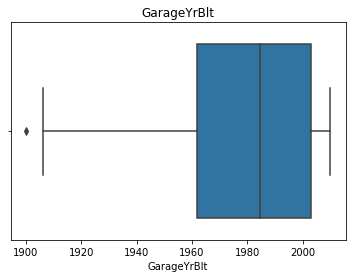

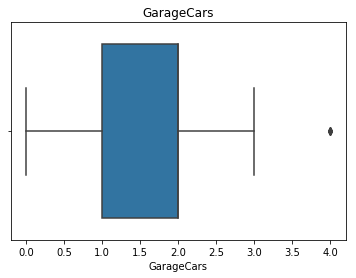

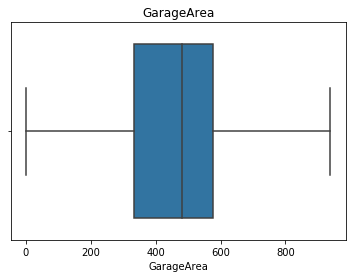

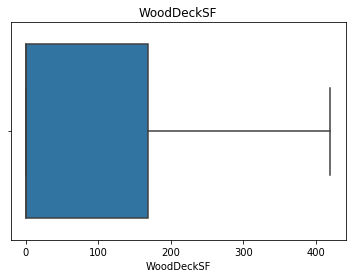

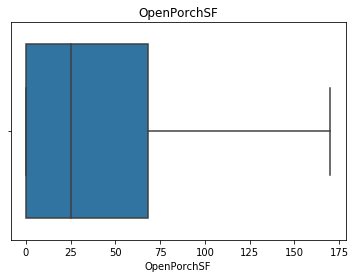

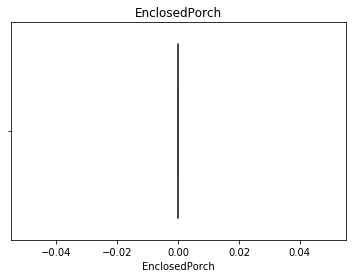

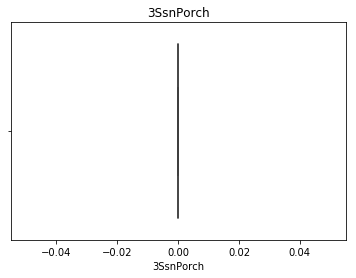

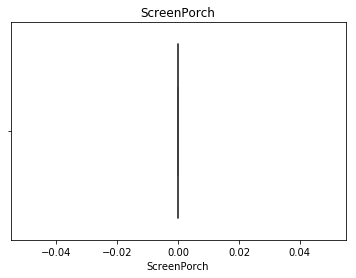

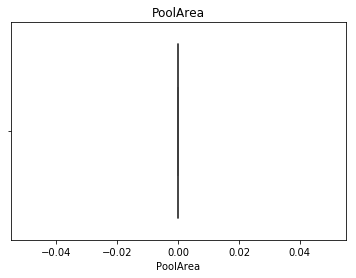

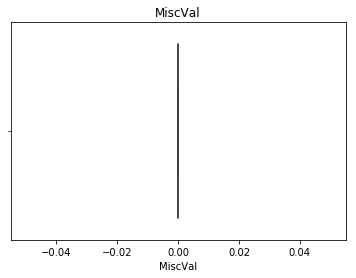

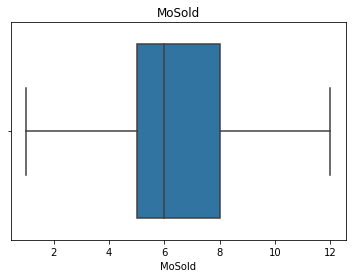

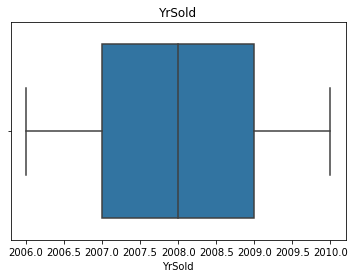

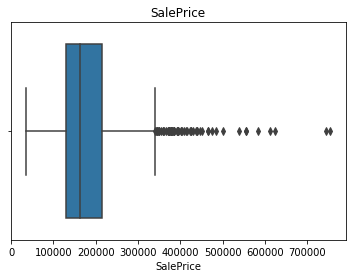

In [43]:
univariate_continuos(df)

# Data Preparation

## Feature Encoding

These are the variable which has 'NA' values.

The approach we take here is : Create dummies for all the categorical variables and for those which have 'NA' values, we drop the 'NA' dummy variable.

In [44]:
na_cat_cols

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [45]:
cat_cols = [cname for cname in df.columns if df[cname].dtype in ['object']]

for col in cat_cols:
    if col in na_cat_cols:
        na_dummy = pd.get_dummies(df[col], prefix=col)
        del na_dummy[col+'_'+'na']
        df = pd.concat([df, na_dummy], axis=1)
        del df[col]
    else:
        dummy = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummy], axis=1)
        del df[col]

In [46]:
list(df.columns)

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_fv',
 'MSZoning_rh',
 'MSZoning_rl',
 'MSZoning_rm',
 'Street_pave',
 'Alley_grvl',
 'Alley_pave',
 'LotShape_ir2',
 'LotShape_ir3',
 'LotShape_reg',
 'LandContour_hls',
 'LandContour_low',
 'LandContour_lvl',
 'Utilities_nosewa',
 'LotConfig_culdsac',
 'LotConfig_fr2',
 'LotConfig_fr3',
 'LotConfig_inside',
 'LandSlope_mod',
 'LandSlope_sev',
 'Neighborhood_blueste',
 'Neighborhood_brdale',
 'Neighborhood_brkside',
 'Neighborhood_clea

In [47]:
df.shape

(1460, 262)

Including the target variable, we have 262 columns after dummyfication.

## Train Test Split & Scaling

In [48]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

Used MinMax Scaler to bring all the values between 0 and 1 as we have dummy variables whose values are 0 and 1.

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numeric_cols = [cname for cname in df.columns if 
                                df[cname].dtype in ['int64', 'float64']]

df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [50]:
df_train.describe()

MSSubClass  LotFrontage      LotArea  OverallQual  OverallCond  \
count  1021.000000  1021.000000  1021.000000  1021.000000  1021.000000   
mean      0.291675     0.350641     0.502100     0.565676     0.513345   
std       0.305785     0.237280     0.221465     0.155529     0.239528   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.193833     0.368536     0.444444     0.375000   
50%       0.240000     0.343612     0.495354     0.555556     0.375000   
75%       0.400000     0.502203     0.619578     0.666667     0.625000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  BsmtFinSF2  \
count  1021.000000   1021.000000  1021.000000  1021.000000      1021.0   
mean      0.719215      0.582305     0.217375     0.248840         0.0   
std       0.219897      0.343843     0.326294     0.243935         0.0   
min       0.000000      0.000000     0.000000     0.000000         0.0   
25%       0.594203      0.283333     0.000000     0.000000         0.0   
50%       0.731884      0.733333     0.000000     0.220147         0.0   
75%       0.927536      0.900000     0.385542     0.399860         0.0   
max       1.000000      1.000000     1.000000     1.000000         0.0   

               ...            SaleType_conlw  SaleType_cwd  SaleType_new  \
count          ...               1021.000000   1021.000000   1021.000000   
mean           ...                  0.003918      0.003918      0.078355   
std            ...                  0.062500      0.062500      0.268860   
min            ...                  0.000000      0.000000      0.000000   
25%            ...                  0.000000      0.000000      0.000000   
50%            ...                  0.000000      0.000000      0.000000   
75%            ...                  0.000000      0.000000      0.000000   
max            ...                  1.000000      1.000000      1.000000   

       SaleType_oth  SaleType_wd  SaleCondition_adjland  SaleCondition_alloca  \
count   1021.000000  1021.000000            1021.000000           1021.000000   
mean       0.002938     0.870715               0.002938              0.007835   
std        0.054153     0.335680               0.054153              0.088214   
min        0.000000     0.000000               0.000000              0.000000   
25%        0.000000     1.000000               0.000000              0.000000   
50%        0.000000     1.000000               0.000000              0.000000   
75%        0.000000     1.000000               0.000000              0.000000   
max        1.000000     1.000000               1.000000              1.000000   

       SaleCondition_family  SaleCondition_normal  SaleCondition_partial  
count           1021.000000           1021.000000            1021.000000  
mean               0.013712              0.825661               0.078355  
std                0.116350              0.379587               0.268860  
min                0.000000              0.000000               0.000000  
25%                0.000000              1.000000               0.000000  
50%                0.000000              1.000000               0.000000  
75%                0.000000              1.000000               0.000000  
max                1.000000              1.000000               1.000000  

[8 rows x 262 columns]

In [51]:
df_test.describe()

MSSubClass  LotFrontage     LotArea  OverallQual  OverallCond  \
count  438.000000   438.000000  438.000000   438.000000   438.000000   
mean     0.254977     0.353399    0.509877     0.568493     0.505422   
std      0.285334     0.236175    0.223452     0.149493     0.244518   
min      0.000000     0.000000   -0.010928     0.000000     0.000000   
25%      0.000000     0.169604    0.387429     0.444444     0.375000   
50%      0.240000     0.387665    0.488408     0.555556     0.375000   
75%      0.320000     0.519824    0.631186     0.666667     0.625000   
max      1.000000     1.000000    1.000000     1.000000     1.000000   

        YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
count  438.000000    438.000000  438.000000  438.000000       438.0   
mean     0.719195      0.577816    0.221060    0.242512         0.0   
std      0.216762      0.345295    0.320871    0.242035         0.0   
min      0.021739      0.000000    0.000000    0.000000         0.0   
25%      0.594203      0.266667    0.000000    0.000000         0.0   
50%      0.724638      0.716667    0.000000    0.202457         0.0   
75%      0.934783      0.900000    0.419277    0.398596         0.0   
max      0.992754      1.000000    1.000000    1.000000         0.0   

               ...            SaleType_conlw  SaleType_cwd  SaleType_new  \
count          ...                438.000000         438.0    438.000000   
mean           ...                  0.002283           0.0      0.095890   
std            ...                  0.047782           0.0      0.294778   
min            ...                  0.000000           0.0      0.000000   
25%            ...                  0.000000           0.0      0.000000   
50%            ...                  0.000000           0.0      0.000000   
75%            ...                  0.000000           0.0      0.000000   
max            ...                  1.000000           0.0      1.000000   

       SaleType_oth  SaleType_wd  SaleCondition_adjland  SaleCondition_alloca  \
count         438.0   438.000000             438.000000            438.000000   
mean            0.0     0.860731               0.002283              0.009132   
std             0.0     0.346623               0.047782              0.095235   
min             0.0     0.000000               0.000000              0.000000   
25%             0.0     1.000000               0.000000              0.000000   
50%             0.0     1.000000               0.000000              0.000000   
75%             0.0     1.000000               0.000000              0.000000   
max             0.0     1.000000               1.000000              1.000000   

       SaleCondition_family  SaleCondition_normal  SaleCondition_partial  
count            438.000000            438.000000             438.000000  
mean               0.013699              0.808219               0.102740  
std                0.116370              0.394152               0.303966  
min                0.000000              0.000000               0.000000  
25%                0.000000              1.000000               0.000000  
50%                0.000000              1.000000               0.000000  
75%                0.000000              1.000000               0.000000  
max                1.000000              1.000000               1.000000  

[8 rows x 262 columns]

In [52]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [53]:
y_test = df_test.pop('SalePrice')
X_test = df_test

# Multicollinearity

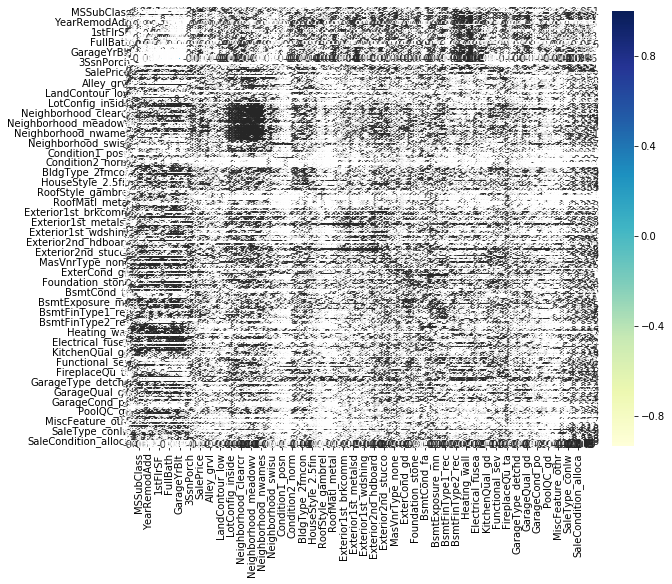

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

This is very hard to interpret and since we are using Regularization techniques, we don't need to explicitly handle multi-collinearity.

# Ridge Regression

Took a good range of hyper-parameter values for tuning.

Choice of folds is 5.

Choice of scoring metric is 'R2 -> R Squared'.

Regularization

In [55]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [56]:
model_cv.best_params_

{'alpha': 7.0}

This is the best value of the hyper-parameter as considered by the model.

In [57]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.039395      0.047107         0.003859        0.004278      0.0001   
1       0.007363      0.001019         0.001808        0.000385       0.001   
2       0.006361      0.000305         0.001330        0.000074        0.01   
3       0.005937      0.000329         0.001393        0.000143        0.05   
4       0.006173      0.000815         0.001358        0.000101         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.851279           0.804989           0.724803   
1   {'alpha': 0.001}           0.851607           0.805035           0.725248   
2    {'alpha': 0.01}           0.854387           0.805376           0.729446   
3    {'alpha': 0.05}           0.861357           0.805385           0.743910   
4     {'alpha': 0.1}           0.865598           0.804303           0.756172   

   split3_test_score       ...         mean_test_score  std_test_score  \
0           0.882392       ...                0.829080        0.059257   
1           0.882549       ...                0.829288        0.059160   
2           0.883946       ...                0.831129        0.058217   
3           0.887635       ...                0.836240        0.054598   
4           0.889438       ...                0.839474        0.051247   

   rank_test_score  split0_train_score  split1_train_score  \
0               25            0.953074            0.946989   
1               23            0.953073            0.946988   
2               22            0.953042            0.946959   
3               21            0.952528            0.946503   
4               20            0.951502            0.945680   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.952470            0.949987            0.949785   
1            0.952469            0.949987            0.949785   
2            0.952449            0.949955            0.949754   
3            0.952089            0.949424            0.949252   
4            0.951348            0.948379            0.948278   

   mean_train_score  std_train_score  
0          0.950461         0.002172  
1          0.950461         0.002172  
2          0.950432         0.002174  
3          0.949959         0.002185  
4          0.949037         0.002177  

[5 rows x 21 columns]

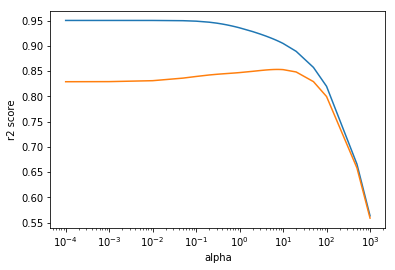

In [58]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

As can be clearly seen from the above plot between hyper-parameter and the r2 score for each one, the train and test scores seems to converge at the value of hyper-parameter => 100.

Let's check by building different models with different values of alpha and see which one yields better accuracy in both train and test.

## Model 1 (alpha=10)

In [59]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm1_ridge = Ridge(alpha=10)
lm1_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm1_ridge.predict(X_train)
y_test_pred = lm1_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm1_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.9026537793512099
Test R2 Score => 0.8685778533775241
Count of variables => 248

Trained AIC => -6367.71942690268
Test AIC => -2289.324438929169

Trained BIC => -5081.371056361702
Test BIC => -1223.8653033209164


## Model 2 (alpha=100)

In [60]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm2_ridge = Ridge(alpha=100)
lm2_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm2_ridge.predict(X_train)
y_test_pred = lm2_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm2_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.8296998890451276
Test R2 Score => 0.8140393181283925
Count of variables => 248

Trained AIC => -5796.686041530661
Test AIC => -2137.2856037854917

Trained BIC => -4510.337670989684
Test BIC => -1071.8264681772391


## Model 3 (alpha=1000)

In [61]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm3_ridge = Ridge(alpha=1000)
lm3_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm3_ridge.predict(X_train)
y_test_pred = lm3_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm3_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.5970942132203197
Test R2 Score => 0.5772614519735495
Count of variables => 248

Trained AIC => -4917.46157498205
Test AIC => -1777.591841831802

Trained BIC => -3631.113204441072
Test BIC => -712.1327062235493


## Model 4 (alpha=1)

In [62]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm4_ridge = Ridge(alpha=1)
lm4_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm4_ridge.predict(X_train)
y_test_pred = lm4_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm4_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.9317943572312433
Test R2 Score => 0.8536694133329019
Count of variables => 248

Trained AIC => -6730.936714477148
Test AIC => -2242.259710049435

Trained BIC => -5444.58834393617
Test BIC => -1176.8005744411823


## Model 5 (alpha=0.1)

In [63]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm5_ridge = Ridge(alpha=0.1)
lm5_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm5_ridge.predict(X_train)
y_test_pred = lm5_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm5_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.9448803049037644
Test R2 Score => 0.7738446886052598
Count of variables => 248

Trained AIC => -6948.430343697683
Test AIC => -2051.5748212025305

Trained BIC => -5662.081973156706
Test BIC => -986.1156855942779


## Model 6 (alpha=7)

In [64]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm6_ridge = Ridge(alpha=7)
lm6_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm6_ridge.predict(X_train)
y_test_pred = lm6_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm5_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.9081905925221389
Test R2 Score => 0.8700375273191856
Count of variables => 248

Trained AIC => -6427.508307222549
Test AIC => -2294.2164163858124

Trained BIC => -5141.159936681572
Test BIC => -1228.7572807775598


## Ridge Model Selection

Clearly, Model 6 has better accuracy and the difference between train and test is not huge. Also, the AIC & BIC values look better compared to the others.

We will take Model 1 as our final model for Ridge Regression and below we find the model parameters (variable coefficients).

In [65]:
# ridge model parameters
ridge_model_parameters = list(lm6_ridge.coef_)
ridge_model_parameters.insert(0, lm6_ridge.intercept_)
ridge_model_parameters = [round(x, 3) for x in ridge_model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, ridge_model_parameters))

[('constant', -0.032),
 ('MSSubClass', -0.02),
 ('LotFrontage', 0.003),
 ('LotArea', 0.029),
 ('OverallQual', 0.06),
 ('OverallCond', 0.027),
 ('YearBuilt', 0.014),
 ('YearRemodAdd', 0.015),
 ('MasVnrArea', 0.009),
 ('BsmtFinSF1', 0.042),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.012),
 ('TotalBsmtSF', 0.044),
 ('1stFlrSF', 0.056),
 ('2ndFlrSF', 0.063),
 ('LowQualFinSF', 0.0),
 ('GrLivArea', 0.051),
 ('BsmtFullBath', 0.011),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.026),
 ('HalfBath', 0.009),
 ('BedroomAbvGr', -0.004),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', 0.016),
 ('Fireplaces', 0.016),
 ('GarageYrBlt', 0.004),
 ('GarageCars', 0.023),
 ('GarageArea', 0.021),
 ('WoodDeckSF', 0.009),
 ('OpenPorchSF', 0.005),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('MiscVal', 0.0),
 ('MoSold', -0.002),
 ('YrSold', -0.003),
 ('MSZoning_fv', 0.009),
 ('MSZoning_rh', 0.006),
 ('MSZoning_rl', 0.009),
 ('MSZoning_rm', 0.005),
 ('Street_pave', 0.002),
 ('Alley

In [66]:
lm6_ridge.get_params()

{'alpha': 7,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [67]:
from operator import itemgetter

variables = sorted(list(zip(cols, ridge_model_parameters)),key=itemgetter(1))

for v in variables:
    if v[1] != 0 and abs(v[1]) > 0.01 :
        print(str(v[0]) + ' : ' + str(round(v[1],2)))

PoolQC_gd : -0.04
Condition2_posn : -0.04
constant : -0.03
KitchenQual_gd : -0.03
KitchenQual_ta : -0.03
Neighborhood_edwards : -0.03
Neighborhood_mitchel : -0.02
MSSubClass : -0.02
KitchenQual_fa : -0.02
ExterQual_ta : -0.02
BldgType_duplex : -0.02
Neighborhood_names : -0.01
Condition1_rrae : -0.01
LotShape_ir3 : -0.01
LotConfig_fr2 : -0.01
BsmtQual_gd : -0.01
Neighborhood_sawyer : -0.01
BldgType_2fmcon : -0.01
ExterQual_gd : -0.01
GarageQual_fa : -0.01
Neighborhood_idotrr : -0.01
Neighborhood_oldtown : -0.01
Exterior2nd_wd shng : -0.01
BsmtQual_ta : -0.01
BsmtExposure_no : -0.01
BsmtFullBath : 0.01
LotConfig_culdsac : 0.01
Condition2_posa : 0.01
BsmtUnfSF : 0.01
YearBuilt : 0.01
YearRemodAdd : 0.02
LandContour_hls : 0.02
LandContour_lvl : 0.02
Condition1_norm : 0.02
TotRmsAbvGrd : 0.02
Fireplaces : 0.02
Condition2_norm : 0.02
Neighborhood_somerst : 0.02
FireplaceQu_ex : 0.02
Functional_typ : 0.02
Exterior2nd_imstucc : 0.02
GarageArea : 0.02
Exterior1st_brkface : 0.02
BsmtExposure_gd 

We filtered out variables with their coefficient's absolute values > 0.01 since there are 248 of them in total.

# Lasso Regression

In [68]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [69]:
model_cv.best_params_

{'alpha': 0.0001}

This is the best value of the hyper-parameter as considered by the model.

In [70]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.017006      0.003022         0.001599        0.000624      0.0001   
1       0.009217      0.004454         0.001065        0.000047       0.001   
2       0.005328      0.001225         0.001205        0.000298        0.01   
3       0.003663      0.000479         0.001092        0.000108        0.05   
4       0.003901      0.001742         0.000973        0.000101         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.893539           0.827369           0.822373   
1   {'alpha': 0.001}           0.882744           0.782532           0.834508   
2    {'alpha': 0.01}           0.547506           0.415764           0.499583   
3    {'alpha': 0.05}          -0.012776          -0.008899          -0.000067   
4     {'alpha': 0.1}          -0.012776          -0.008899          -0.000067   

   split3_test_score       ...         mean_test_score  std_test_score  \
0           0.900621       ...                0.867504        0.034913   
1           0.874857       ...                0.838592        0.037004   
2           0.541494       ...                0.479708        0.063671   
3          -0.003405       ...               -0.005666        0.004560   
4          -0.003405       ...               -0.005666        0.004560   

   rank_test_score  split0_train_score  split1_train_score  \
0                1            0.935564            0.934357   
1                2            0.851604            0.866659   
2                3            0.494807            0.479320   
3                4            0.000000            0.000000   
4                4            0.000000            0.000000   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.936508            0.935692            0.933325   
1            0.865112            0.851737            0.852437   
2            0.480486            0.507247            0.485411   
3            0.000000            0.000000            0.000000   
4            0.000000            0.000000            0.000000   

   mean_train_score  std_train_score  
0          0.935089         0.001118  
1          0.857510         0.006862  
2          0.489454         0.010438  
3          0.000000         0.000000  
4          0.000000         0.000000  

[5 rows x 21 columns]

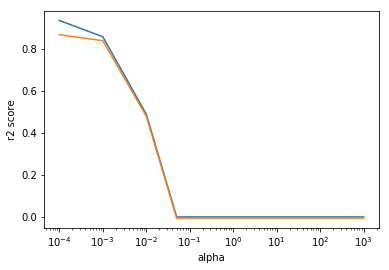

In [71]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

As can be clearly seen from the above plot between hyper-parameter and the r2 score for each one, the train and test scores seems to converge at the value of hyper-parameter => 0.001.

Let's check by building different models with different values of alpha and see which one yields better accuracy in both train and test.

## Model 1 (alpha=0.001)

In [72]:
from sklearn import metrics

# model with optimal alpha
# lasso regression
lm1_lasso = Lasso(alpha=0.001)
lm1_lasso.fit(X_train, y_train)

# predict
y_train_pred = lm1_lasso.predict(X_train)
y_test_pred = lm1_lasso.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm1_lasso.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.852355423485485
Test R2 Score => 0.8305185848070978
Count of variables => 35

Trained AIC => -5942.438246886339
Test AIC => -2177.9284943767025

Trained BIC => -4656.089876345361
Test BIC => -1112.4693587684499


## Model 2 (alpha=0.01)

In [73]:
from sklearn import metrics

# model with optimal alpha
# lasso regression
lm2_lasso = Lasso(alpha=0.01)
lm2_lasso.fit(X_train, y_train)

# predict
y_train_pred = lm2_lasso.predict(X_train)
y_test_pred = lm2_lasso.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm2_lasso.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.4891433029250769
Test R2 Score => 0.4686144592892072
Count of variables => 11

Trained AIC => -4675.090101719583
Test AIC => -1677.4063826929018

Trained BIC => -3388.7417311786053
Test BIC => -611.9472470846492


## Model 3 (alpha=0.1)

In [74]:
from sklearn import metrics

# model with optimal alpha
# lasso regression
lm3_lasso = Lasso(alpha=0.1)
lm3_lasso.fit(X_train, y_train)

# predict
y_train_pred = lm3_lasso.predict(X_train)
y_test_pred = lm3_lasso.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm3_lasso.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.0
Test R2 Score => -0.00030262183303753076
Count of variables => 0

Trained AIC => -3989.318947907381
Test AIC => -1400.340708728716

Trained BIC => -2702.970577366403
Test BIC => -334.8815731204634


## Model 4 (alpha=0.0001)

In [75]:
from sklearn import metrics

# model with optimal alpha
# lasso regression
lm4_lasso = Lasso(alpha=0.0001)
lm4_lasso.fit(X_train, y_train)

# predict
y_train_pred = lm4_lasso.predict(X_train)
y_test_pred = lm4_lasso.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm4_lasso.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.930519466060732
Test R2 Score => 0.8211776584803465
Count of variables => 120

Trained AIC => -6712.028482465102
Test AIC => -2154.429999546928

Trained BIC => -5425.6801119241245
Test BIC => -1088.9708639386752


## Lasso Model Selection

Clearly, Model 1 has better accuracy and the difference between train and test is not huge besides having lesser number of variables.  Also, the AIC & BIC values look better compared to the others.

We will take Model 1 as our final model for Lasso Regression and below we find the model parameters (variable coefficients).

In [76]:
# ridge model parameters
lasso_model_parameters = list(lm1_lasso.coef_)
lasso_model_parameters.insert(0, lm1_lasso.intercept_)
lasso_model_parameters = [round(x, 3) for x in lasso_model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, lasso_model_parameters))

[('constant', -0.023),
 ('MSSubClass', -0.01),
 ('LotFrontage', 0.0),
 ('LotArea', 0.027),
 ('OverallQual', 0.122),
 ('OverallCond', 0.006),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 0.02),
 ('MasVnrArea', 0.003),
 ('BsmtFinSF1', 0.033),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.05),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 0.0),
 ('GrLivArea', 0.145),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.0),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.018),
 ('GarageYrBlt', 0.0),
 ('GarageCars', 0.0),
 ('GarageArea', 0.032),
 ('WoodDeckSF', 0.002),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('MiscVal', 0.0),
 ('MoSold', 0.0),
 ('YrSold', -0.0),
 ('MSZoning_fv', 0.0),
 ('MSZoning_rh', -0.0),
 ('MSZoning_rl', 0.0),
 ('MSZoning_rm', -0.007),
 ('Street_pave', 0.0),
 ('Alley_grvl', -0.0),
 ('Alley_pave', 0.0),
 (

In [77]:
lm1_lasso.get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [78]:
from operator import itemgetter

variables = sorted(list(zip(cols, lasso_model_parameters)),key=itemgetter(1))

for v in variables:
    if v[1] != 0 and abs(v[1]) > 0.01 :
        print(str(v[0]) + ' : ' + str(round(v[1],2)))

constant : -0.02
ExterQual_ta : -0.01
Neighborhood_nridght : 0.02
BsmtExposure_gd : 0.02
Fireplaces : 0.02
YearRemodAdd : 0.02
LotArea : 0.03
GarageArea : 0.03
BsmtFinSF1 : 0.03
Neighborhood_noridge : 0.04
TotalBsmtSF : 0.05
BsmtQual_ex : 0.06
OverallQual : 0.12
GrLivArea : 0.14


We filtered out variables with their coefficient's absolute values > 0.01 since there are 35 of them in total.

In [79]:
ridge_variables = []

for v in variables:
    if v[1] != 0 and v[0]!='constant':
        ridge_variables.append(v[0])
        
ridge_variables

['ExterQual_ta',
 'MSSubClass',
 'BsmtExposure_no',
 'KitchenQual_ta',
 'MSZoning_rm',
 'Neighborhood_edwards',
 'BsmtQual_ta',
 'HeatingQC_ta',
 'Neighborhood_somerst',
 'FireplaceQu_gd',
 'WoodDeckSF',
 'CentralAir_y',
 'GarageType_attchd',
 'SaleType_new',
 'MasVnrArea',
 'Foundation_pconc',
 'OverallCond',
 'BsmtFinType1_glq',
 'Functional_typ',
 'Condition1_norm',
 'GarageFinish_fin',
 'Neighborhood_nridght',
 'BsmtExposure_gd',
 'Fireplaces',
 'YearRemodAdd',
 'LotArea',
 'GarageArea',
 'BsmtFinSF1',
 'Neighborhood_noridge',
 'TotalBsmtSF',
 'BsmtQual_ex',
 'OverallQual',
 'GrLivArea']

The features selected by Lasso will be used to build a Ridge regression model again.

# Ride Regression Again

In [80]:
X_train = X_train[ridge_variables]

In [81]:
X_test = X_test[ridge_variables]

In [82]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [83]:
model_cv.best_params_

{'alpha': 1.0}

This is the best value of the hyper-parameter as considered by the model.

In [84]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.004076      0.001623         0.001600        0.000539      0.0001   
1       0.003416      0.001853         0.001098        0.000262       0.001   
2       0.002402      0.000387         0.000834        0.000122        0.01   
3       0.002388      0.000357         0.000929        0.000140        0.05   
4       0.002955      0.000639         0.001342        0.000451         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.879260           0.811228           0.847661   
1   {'alpha': 0.001}           0.879262           0.811225           0.847663   
2    {'alpha': 0.01}           0.879286           0.811195           0.847688   
3    {'alpha': 0.05}           0.879388           0.811059           0.847797   
4     {'alpha': 0.1}           0.879515           0.810891           0.847930   

   split3_test_score       ...         mean_test_score  std_test_score  \
0           0.874004       ...                0.854278        0.024224   
1           0.874007       ...                0.854279        0.024225   
2           0.874037       ...                0.854287        0.024244   
3           0.874166       ...                0.854321        0.024327   
4           0.874325       ...                0.854362        0.024431   

   rank_test_score  split0_train_score  split1_train_score  \
0               16            0.864378            0.883130   
1               15            0.864378            0.883130   
2               14            0.864378            0.883130   
3               13            0.864378            0.883129   
4               12            0.864375            0.883127   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.871905            0.866250            0.868134   
1            0.871905            0.866250            0.868134   
2            0.871905            0.866250            0.868134   
3            0.871904            0.866249            0.868133   
4            0.871901            0.866246            0.868131   

   mean_train_score  std_train_score  
0          0.870759         0.006668  
1          0.870759         0.006668  
2          0.870759         0.006668  
3          0.870759         0.006668  
4          0.870756         0.006668  

[5 rows x 21 columns]

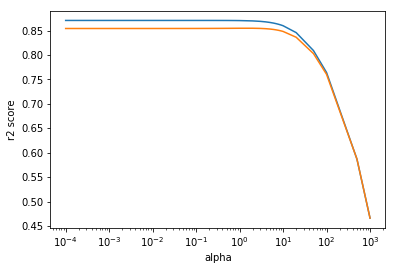

In [85]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

As can be clearly seen from the above plot between hyper-parameter and the r2 score for each one, the train and test scores seems to converge at the value of hyper-parameter => 100.

Let's check by building different models with different values of alpha and see which one yields better accuracy in both train and test.

## Model 1 (alpha=100)

In [86]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm1_ridge = Ridge(alpha=100)
lm1_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm1_ridge.predict(X_train)
y_test_pred = lm1_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm1_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.7787622909019386
Test R2 Score => 0.7530389248903007
Count of variables => 33

Trained AIC => -5985.515365167174
Test AIC => -2469.0269879343928

Trained BIC => -5822.87361716774
Test BIC => -2334.31376389197


## Model 2 (alpha=10)

In [87]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm2_ridge = Ridge(alpha=10)
lm2_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm2_ridge.predict(X_train)
y_test_pred = lm2_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm1_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.860804468698912
Test R2 Score => 0.8366306764129496
Count of variables => 33

Trained AIC => -6458.603970547274
Test AIC => -2650.0161683586653

Trained BIC => -6295.96222254784
Test BIC => -2515.3029443162427


## Model 3 (alpha=1)

In [88]:
from sklearn import metrics

# model with optimal alpha
# ride regression
lm3_ridge = Ridge(alpha=1)
lm3_ridge.fit(X_train, y_train)

# predict
y_train_pred = lm3_ridge.predict(X_train)
y_test_pred = lm3_ridge.predict(X_test)

print("Trained R2 Score => " + str(metrics.r2_score(y_true=y_train, y_pred=y_train_pred)))
print("Test R2 Score => " + str(metrics.r2_score(y_true=y_test, y_pred=y_test_pred)))
print("Count of variables => " + str(np.sum(lm1_ridge.coef_!=0)))
print('')
print("Trained AIC => " + str(aic.aic(y_train, y_train_pred, len(X_train.columns))))
print("Test AIC => " + str(aic.aic(y_test, y_test_pred, len(X_train.columns))))
print('')
print("Trained BIC => " + str(bic.bic(y_train, y_train_pred, len(X_train.columns))))
print("Test BIC => " + str(bic.bic(y_test, y_test_pred, len(X_train.columns))))

Trained R2 Score => 0.8685874348840946
Test R2 Score => 0.8441419900544245
Count of variables => 33

Trained AIC => -6517.350185084018
Test AIC => -2670.6319639829367

Trained BIC => -6354.708437084584
Test BIC => -2535.918739940514


## Ridge Model Selection

Clearly, Model 3 has better accuracy and the difference between train and test is not huge.  Also, the AIC & BIC values look better compared to the others.

We will take Model 3 as our final model for Ridge Regression and below we find the model parameters (variable coefficients).

In [89]:
# ridge model parameters
ridge_model_parameters = list(lm3_ridge.coef_)
ridge_model_parameters.insert(0, lm3_ridge.intercept_)
ridge_model_parameters = [round(x, 3) for x in ridge_model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, ridge_model_parameters))

[('constant', -0.072),
 ('ExterQual_ta', -0.008),
 ('MSSubClass', -0.02),
 ('BsmtExposure_no', -0.012),
 ('KitchenQual_ta', -0.004),
 ('MSZoning_rm', -0.008),
 ('Neighborhood_edwards', -0.017),
 ('BsmtQual_ta', -0.004),
 ('HeatingQC_ta', -0.002),
 ('Neighborhood_somerst', 0.029),
 ('FireplaceQu_gd', -0.002),
 ('WoodDeckSF', 0.007),
 ('CentralAir_y', 0.006),
 ('GarageType_attchd', -0.001),
 ('SaleType_new', 0.012),
 ('MasVnrArea', 0.0),
 ('Foundation_pconc', 0.003),
 ('OverallCond', 0.03),
 ('BsmtFinType1_glq', 0.004),
 ('Functional_typ', 0.019),
 ('Condition1_norm', 0.019),
 ('GarageFinish_fin', 0.01),
 ('Neighborhood_nridght', 0.039),
 ('BsmtExposure_gd', 0.021),
 ('Fireplaces', 0.028),
 ('YearRemodAdd', 0.014),
 ('LotArea', 0.033),
 ('GarageArea', 0.026),
 ('BsmtFinSF1', 0.04),
 ('Neighborhood_noridge', 0.074),
 ('TotalBsmtSF', 0.052),
 ('BsmtQual_ex', 0.055),
 ('OverallQual', 0.129),
 ('GrLivArea', 0.154)]

In [90]:
lm3_ridge.get_params()

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [91]:
from operator import itemgetter

variables = sorted(list(zip(cols, ridge_model_parameters)),key=itemgetter(1))

for v in variables:
    if v[1] != 0 and abs(v[1]) > 0.01 :
        print(str(v[0]) + ' : ' + str(round(v[1],2)))

constant : -0.07
MSSubClass : -0.02
Neighborhood_edwards : -0.02
BsmtExposure_no : -0.01
SaleType_new : 0.01
YearRemodAdd : 0.01
Functional_typ : 0.02
Condition1_norm : 0.02
BsmtExposure_gd : 0.02
GarageArea : 0.03
Fireplaces : 0.03
Neighborhood_somerst : 0.03
OverallCond : 0.03
LotArea : 0.03
Neighborhood_nridght : 0.04
BsmtFinSF1 : 0.04
TotalBsmtSF : 0.05
BsmtQual_ex : 0.06
Neighborhood_noridge : 0.07
OverallQual : 0.13
GrLivArea : 0.15


We filtered out variables with their coefficient's absolute values > 0.01 since there are 33 of them in total.

# Final Predictor Variables

The variable which have higher value of coefficients for Ridge and Lasso match and hence below are our final most important predictor variables.

1) TotalBsmtSF with a +ve coefficient => More the basement area, more the price.

2) BsmtQual_ex with a +ve coefficient => Higher the price for houses with basement height > 100 inches.

3) OverallQual with a +ve coefficient => More the overall material quality and finish, more the price.

4) GrLivArea with a +ve coefficient => More the living area, more the price.

5) Neighborhood_noridge with a +ve coefficient => Neighbourhoods of noridge demand more price.


There are other variables with weak -ve coefficients like MSSubClass, Neighborhood_edwards but they are not that significant compared to the +ve ones. Hence, not considered in the final variable list.